<a href="https://colab.research.google.com/github/yonjoos/Python/blob/main/%EC%99%9C%EC%95%88%EB%8F%BC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob
import os
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import folium
from IPython.display import display



print("...beginning loading data...")
curr_file_list = os.listdir('/content/drive/MyDrive/Prj/pattern_create/RNN/GET_DATA/preprocessing/txt/ASW')
#glob.glob(os.path.join('../GET_DATA/preprocessing/txt/ASW', '*txt'))
curr_file_list=sorted(curr_file_list)
print(curr_file_list)
DataList=[]
c=0
for filename in curr_file_list:
  with open('/content/drive/MyDrive/Prj/pattern_create/RNN/GET_DATA/preprocessing/txt/ASW/'+filename) as file:
    data = pd.read_csv(file, sep='\t', header=None, names=['dateGMT', 'timeGMT', 'unixTime', 'lat', 'lon'])
    data["timeGMT"] = data["timeGMT"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
    data["timeGMT"] = data["timeGMT"].str.replace(pat=r':', repl=r'', regex=True)
    data["dateGMT"] = data["dateGMT"].str.replace(pat=r'|', repl='', regex=True)
    data["unixTime"] = data["unixTime"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
#         data["dateTimeGMT"] = pd.to_datetime(data["dateGMT"]+data["timeGMT"], format='%Y%m%d%H%M%S')
    data.drop(['dateGMT', 'timeGMT','unixTime'], axis=1, inplace=True)
    DataList.append([c,data])
    c+=1

print(DataList)


...beginning loading data...
['20190816_ASW.txt', '20190820_ASW.txt', '20190826_ASW.txt', '20190830_ASW.txt', '20190901_ASW.txt', '20191120_ASW.txt', '20191229_ASW.txt', '20191231_ASW.txt', '20200101_ASW.txt', '20200104_ASW.txt', '20200107_ASW.txt', '20200113_ASW.txt', '20200114_ASW.txt', '20200116_ASW.txt', '20200120_ASW.txt', '20200121_ASW.txt', '20200124_ASW.txt', '20200130_ASW.txt']
[[0,             lat         lon
0     37.550163  126.924373
1     37.550070  126.924358
2     37.550213  126.924282
3     37.550138  126.924270
4     37.550030  126.924095
...         ...         ...
1024  37.299580  126.972263
1025  37.299480  126.972207
1026  37.299368  126.972190
1027  37.299272  126.972150
1028  37.299183  126.972063

[1029 rows x 2 columns]], [1,            lat         lon
0    37.537877  126.941077
1    37.537935  126.941022
2    37.537998  126.940972
3    37.538082  126.940927
4    37.538132  126.940860
..         ...         ...
258  37.547368  126.922940
259  37.547442  126.92

In [4]:
#후버사인 : A(lon1, lat2), B(lon2, lat2) 사이 거리 구하는 함수
# Input : A, B의 위도, 경도
# output : A, B 사이의 거리 / 단위 : km

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [5]:
# df[index] 랑 df[index + 1] 사이의 거리 궇는 함수
# input : 위치 데이터, 계산 하고자하는 위치 데이터의 index
# output : index번째 위치라아 index + 1 번째 위치 사이의 거리

def make_continue_route(df,index):

    lat,lon=df.iloc[index] # df중 index 행
    n_lat,n_lon=df.iloc[index+1] # 그 다음 행
    d=haversine(lat,lon,n_lat,n_lon) #input지점과 바로 그 다음 지점 사이의 거리 out

    return d

In [6]:
def avd(d): # 평균 구하는 함수
    return np.mean(d)

#**run predict 함수**
###**함수 형태** : run_predict(예측할 데이터, training 할 window size)
> **input** : 예측할데이터(data), 윈도우크기(w)      
> **output** : 평균값 of 예측값과 실제 값의 차이         

###**함수 내부 변수** :
> **data_sc_df** : data 에서 Scaled data 뽑아서 담는 변수          
> **k** : w - 1 (w = window size)     
> **X_data** : 이유는 모르겠지만...





In [7]:
def run_predict(data,w):
    '''
    하이퍼 파라미터 최적화 실행함수
    input: train, validation ,w(window_size): 목적함수
    output: harversine으로 계산한 예측 값과 실제 값의 차이(error)의 평균 값
    '''
    data_sc_df=data
    w=w
    for s in range(1, w):
        data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

    k=w-1
    X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
    y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False,random_state=0)

    X_train=X_train.values
    X_test=X_test.values
    y_train=y_train.values
    y_test=y_test.values

    X_train_t = X_train.reshape(X_train.shape[0], k, 2)
    X_test_t=X_test.reshape(X_test.shape[0],k,2)

    K.clear_session()
    model = Sequential() # Sequeatial Model
    model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
    model.add(Dense(2)) # output = 1
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

    p=5 #int(input('patience : '))
    early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

    result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test),
              batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

    y_pred = model.predict(X_test_t)
    y_pred = sc.inverse_transform(y_pred)
    y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
    Y_validation=sc.inverse_transform(y_test)

    loss_and_metrics = model.evaluate(X_test_t, y_test)
    df_ = pd.DataFrame({'lat':Y_validation[:,0], 'lon':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
    d=[]
    for i in range(len(df_)):
         d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

    return avd(d),d[-1],result,df_,y_pred_df,loss_and_metrics

In [8]:
def run_optimization(data,w):
    '''
    하이퍼 파라미터 최적화 실행함수
    input: train, validation ,w(window_size): 목적함수
    output: harversine으로 계산한 예측 값과 실제 값의 차이(error)의 평균 값
    '''
    data_sc_df=data
    w=w
    for s in range(1, w):
        data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

    k=w-1
    X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
    y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False, random_state=0)

    X_train=X_train.values
    X_test=X_test.values
    y_train=y_train.values
    y_test=y_test.values

    X_train_t = X_train.reshape(X_train.shape[0], k, 2)
    X_test_t=X_test.reshape(X_test.shape[0],k,2)

    K.clear_session()
    model = Sequential() # Sequeatial Model
    model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
    model.add(Dense(2)) # output = 1
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

    p=5 #int(input('patience : '))
    early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

    result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test),
              batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

    y_pred = model.predict(X_test_t)
    y_pred = sc.inverse_transform(y_pred)
    y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
    Y_validation=sc.inverse_transform(y_test)
    df_ = pd.DataFrame({'위도':Y_validation[:,0], '경도':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
    d=[]
    for i in range(len(df_)):
         d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

    return avd(d)

In [ ]:
"""
Datas = []
for i in range(0,18):
  Datas.append(DataList[i][1])


for i in range(0, 18):
  len = DataList[i][1].shape[0]
  print(i)
  print("================")
  for j in range(0, len-1):
    if haversine(tmp[i].loc[j][0], tmp[i].loc[j][1], tmp[i].loc[j+1][0], tmp[i].loc[j+1][1]) > 0.05 :
      print(j)
  print("===============")

"""

In [27]:
Datas = []
DataPoints = []

for i in range(0,18):
  Datas.append(DataList[i][1])

for i in range(0, 18):
  len = DataList[i][1].shape[0]
  print(i)
  print("================")
  DataPoint = []
  for j in range(0, len-1):

    if haversine(Datas[i].loc[j][0], Datas[i].loc[j][1], Datas[i].loc[j+1][0], Datas[i].loc[j+1][1]) > 0.05 :
      print(j)
      DataPoint.append([j, Datas[i].loc[j][0], Datas[i].loc[j][1]])
  DataPoints.append(DataPoint)
  print("===============")

0
31
90
350
529
1
195
239
2
3
7
64
145
239
346
4
1
2
5
6
0
2
7
7
0
1
3
4
7
9
13
28
31
32
34
66
69
70
79
81
130
167
168
243
279
280
281
8
2
9
452
960
964
979
980
981
982
9
10
4
5
57
344
347
11
0
3
12
13
14
15
16
157
12
5
40
46
47
49
13
150
154
278
279
281
282
315
318
14
15
68
69
16
51
17
1
65
66
67
249
250
251
291
346
347
349


In [28]:
print(DataPoints[0])
print("=============")
print(DataPoints[1])
print("=============")
print(DataPoints[2])
print("=============")
print(DataPoints[3])
print("=============")
print(DataPoints[4])
print("=============")
print(DataPoints[5])

[[31, 37.54896, 126.92318], [90, 37.448448333333, 126.994328333333], [350, 37.406856666667, 126.995786666667], [529, 37.364603333333, 126.999065]]
[[195, 37.54453, 126.925655], [239, 37.546386666667, 126.923138333333]]
[]
[[7, 37.509241666667, 127.062163333333], [64, 37.48804, 126.913573333333], [145, 37.490163333333, 126.895456666667], [239, 37.504003333333, 126.892831666667], [346, 37.544613333333, 126.911288333333]]
[[1, 37.543825, 126.92802], [2, 37.543158333333, 126.929568333333]]
[]


In [ ]:
dataFront = DataList[1][1].iloc[0:196]
dataBack = DataList[1][1].iloc[196:1028]

indexes = []
for i in range (196, 263):
  indexes.append(i)

dataBack = dataBack.loc[::-1].reset_index(drop=True)
dataBack_lat = list(dataBack['lat'])
dataBack_lon = list(dataBack['lon'])
#dataBack = pd.DataFrame({'lat':dataBack['lat'], 'lon':dataBack['lon']}, index = indexes)
print(type(dataBack))

DataBack = pd.DataFrame({'lat':dataBack_lat, 'lon':dataBack_lon}, index = indexes)



print(dataFront)
print(dataBack)
print(DataBack)






<class 'pandas.core.frame.DataFrame'>
           lat         lon
0    37.537877  126.941077
1    37.537935  126.941022
2    37.537998  126.940972
3    37.538082  126.940927
4    37.538132  126.940860
..         ...         ...
191  37.544240  126.925603
192  37.544315  126.925568
193  37.544387  126.925588
194  37.544457  126.925627
195  37.544530  126.925655

[196 rows x 2 columns]
          lat         lon
0   37.547615  126.922778
1   37.547568  126.922848
2   37.547523  126.922920
3   37.547442  126.922945
4   37.547368  126.922940
..        ...         ...
62  37.544798  126.924650
63  37.544787  126.924770
64  37.544812  126.924858
65  37.544767  126.924933
66  37.544688  126.924857

[67 rows x 2 columns]
           lat         lon
196  37.547615  126.922778
197  37.547568  126.922848
198  37.547523  126.922920
199  37.547442  126.922945
200  37.547368  126.922940
..         ...         ...
258  37.544798  126.924650
259  37.544787  126.924770
260  37.544812  126.924858
261  37.5

In [ ]:
datalist=dataFront

sc = MinMaxScaler()
sc_data=sc.fit_transform(datalist)
sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist.index)


w=int(input('window size: '))
start = time.time() #작동시간 체크 시작


############################################################################
############################################################################
data_sc_df=sc_df

for s in range(1, w):
  data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

k=w-1
X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False,random_state=0)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

X_train_t = X_train.reshape(X_train.shape[0], k, 2)
X_test_t=X_test.reshape(X_test.shape[0],k,2)

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
model.add(Dense(2)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

p=5 #int(input('patience : '))
early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test), batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
Y_validation=sc.inverse_transform(y_test)

loss_and_metrics = model.evaluate(X_test_t, y_test)
df_ = pd.DataFrame({'lat':Y_validation[:,0], 'lon':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
d=[]
for i in range(len(df_)):
  d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

ADE = avd(d)
FDE = d[-1]
r = result
df=df_
pred_df=y_pred_df
lo=loss_and_metrics


############################################################################
############################################################################

# ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w) 얘를 위에걸로 대치



end = time.time() #작동시간 체크 끝
training_time=end-start
      # summarize history for loss
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print('FDE : {}, ADE : {}'.format(FDE,ADE))
print('training time: {}' .format(training_time))
print('data num: {}' .format(len(datalist)))

ASW_map = folium.Map(location=[datalist['lat'].mean(),datalist['lon'].mean()],tiles='Stamen Toner',zoom_start=13)
d=[]

for i in range(len(datalist)-(w-1)):
  folium.Circle([datalist['lat'][i],datalist['lon'][i]],radius=1,color='green').add_to(ASW_map)#, popup=df_cities.index[i]
for i in range(len(pred_df)):
  folium.Circle([pred_df['prediction_lat'][i],pred_df['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
  folium.Circle([df['lat'][i],df['lon'][i]],radius=1,color='orange').add_to(ASW_map)
  d.append(haversine(pred_df['prediction_lat'][i],pred_df['prediction_lon'][i],df['lat'][i],df['lon'][i]))

display(ASW_map)

In [ ]:
datalist2=dataBack

sc = MinMaxScaler()
sc_data=sc.fit_transform(datalist2)
sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist2.index)


w=int(input('window size: '))
start = time.time() #작동시간 체크 시작


############################################################################
############################################################################
data_sc_df=sc_df

for s in range(1, w):
  data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

k=w-1
X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False,random_state=0)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

X_train_t = X_train.reshape(X_train.shape[0], k, 2)
X_test_t=X_test.reshape(X_test.shape[0],k,2)

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
model.add(Dense(2)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

p=5 #int(input('patience : '))
early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test), batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
Y_validation=sc.inverse_transform(y_test)

loss_and_metrics = model.evaluate(X_test_t, y_test)
df_ = pd.DataFrame({'lat':Y_validation[:,0], 'lon':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
d=[]
for i in range(len(df_)):
  d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

ADE2 = avd(d)
FDE2 = d[-1]
r2 = result
df2=df_
pred_df2=y_pred_df
lo2=loss_and_metrics


############################################################################
############################################################################

# ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w) 얘를 위에걸로 대치



end = time.time() #작동시간 체크 끝
training_time=end-start
      # summarize history for loss
plt.plot(r2.history['loss'])
plt.plot(r2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print('FDE : {}, ADE : {}'.format(FDE2,ADE2))
print('training time: {}' .format(training_time))
print('data num: {}' .format(len(datalist)))


for i in range(len(datalist2) - (w-1)):
  folium.Circle([datalist2['lat'][i],datalist2['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]


for i in range(len(pred_df2)):
  folium.Circle([pred_df2['prediction_lat'][i],pred_df2['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
  folium.Circle([df2['lat'][i],df2['lon'][i]],radius=1,color='pink').add_to(ASW_map)
  d.append(haversine(pred_df2['prediction_lat'][i],pred_df2['prediction_lon'][i],df2['lat'][i],df2['lon'][i]))

display(ASW_map)

Dataset: 1
Data Type ENTER (C or N): ㅊ
Running Type ENTER (P or O):P
window size: 4
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.3408 - accuracy: 0.6000 - val_loss: 0.7231 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2922 - accuracy: 0.9333 - val_loss: 0.6270 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2477 - accuracy: 0.9333 - val_loss: 0.5375 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2069 - accuracy: 0.9333 - val_loss: 0.4538 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 59ms/step - loss: 0.1694 - accuracy: 0.9333 - val_loss: 0.3756 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 73ms/step - loss: 0.1354 - accuracy: 0.9333 - val_loss: 0.3030 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 73ms/step - loss: 0.1048

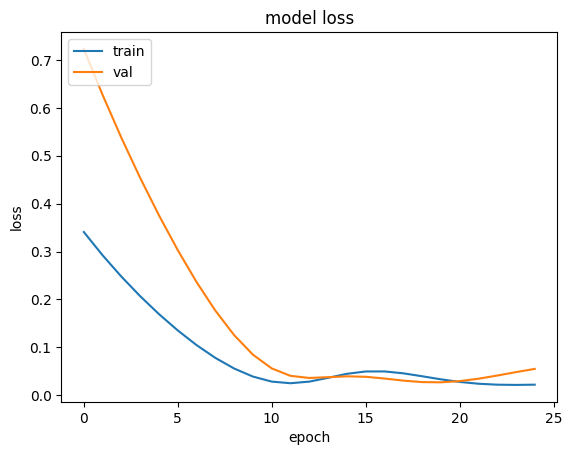

FDE : 0.03608191638157053, ADE : 0.02936787235956438
training time: 5.975268602371216
data num: 22


KeyboardInterrupt: ignored

In [ ]:
while True:
  Data=int(input('Dataset: '))
  Type=input('Data Type ENTER (C or N): ')
  run_type=input('Running Type ENTER (P or O):')

  if Type=='C':
    datalist=DataList[Data][1]

    sc = MinMaxScaler()
    sc_data=sc.fit_transform(datalist)
    sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist.index)

    if run_type=='P':
      w=int(input('window size: '))
      start = time.time() #작동시간 체크 시작
      ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w)
      end = time.time() #작동시간 체크 끝
      training_time=end-start
      # summarize history for loss
      plt.plot(r.history['loss'])
      plt.plot(r.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      print('FDE : {}, ADE : {}'.format(FDE,ADE))
      print('training time: {}' .format(training_time))
      print('data num: {}' .format(len(datalist)))
      ASW_map = folium.Map(location=[datalist['lat'].mean(),datalist['lon'].mean()],tiles='Stamen Toner',zoom_start=13)
      d=[]
      for i in range(len(datalist)-(w-1)):
          folium.Circle([datalist['lat'][i],datalist['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]
      for i in range(len(pred_df)):
          folium.Circle([pred_df['prediction_lat'][i],pred_df['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
          folium.Circle([df['lat'][i],df['lon'][i]],radius=1,color='orange').add_to(ASW_map)
          d.append(haversine(pred_df['prediction_lat'][i],pred_df['prediction_lon'][i],df['lat'][i],df['lon'][i]))

      display(ASW_map)
    elif run_type=='O':
      result=[]
      for i in range(2,20): # grid search 이용하여 window 값 최적화
        result.append(run_optimization(sc_df,i))
        print(i)

      index=result.index(min(result))
      model_num=index+2 #최적화 된 window 값
      print('Data {}\'s Optimized Window Size : {} '.format(Data,model_num)) #최적화 된 error 값
      print(result[model_num])
      plt.bar(range(2,20),result,color='black')
      plt.xlabel('window_size')
      plt.ylabel('ADE')
      plt.show()
    else:
      pass

    a=input('Continue or Break ?(C or B)')
    if a=='C':
      continue
    elif a=='B':
      break
    else:
      break

  else:
    dlist=np.array([])
    try:
      for i in range(len(DataList[Data][1])):
        dlist=np.append(dlist,make_continue_route(DataList[Data][1],i))
    except:
        pass

    stack=[]
    for i in range(len(dlist)):
        if dlist[i]> np.mean(dlist):
            stack.append(i)
    datalist=DataList[Data][1][stack[-1]:-1]

    l=datalist.index.to_list()

    sc = MinMaxScaler()
    sc_data=sc.fit_transform(datalist)
    sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist.index)


    if run_type=='P':
      w=int(input('window size: '))
      start = time.time() #작동시간 체크 시작
      ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w)
      end = time.time() #작동시간 체크 끝
      training_time=end-start
      # summarize history for loss
      plt.plot(r.history['loss'])
      plt.plot(r.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      print('FDE : {}, ADE : {}'.format(FDE,ADE))
      print('training time: {}' .format(training_time))
      print('data num: {}' .format(len(datalist)))

      ASW_map = folium.Map(location=[datalist['lat'].mean(),datalist['lon'].mean()],tiles='Stamen Toner',zoom_start=13)
      d=[]
      for i in l[:-(w-1)]:
          folium.Circle([datalist['lat'][i],datalist['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]
      for i in range(len(pred_df)):
          folium.Circle([pred_df['prediction_lat'][i],pred_df['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
          folium.Circle([df['lat'][i],df['lon'][i]],radius=1,color='orange').add_to(ASW_map)
          d.append(haversine(pred_df['prediction_lat'][i],pred_df['prediction_lon'][i],df['lat'][i],df['lon'][i]))

      display(ASW_map)
    elif run_type=='O':
      result=[]
      for i in range(2,20): # grid search 이용하여 window 값 최적화
        result.append(run_optimization(sc_df,i))
        print(i)

      index=result.index(min(result))
      model_num=index+2 #최적화 된 window 값
      print('Data {}\'s Optimized Window Size : {} '.format(Data,model_num)) #최적화 된 error 값
      print(result[model_num])
      plt.bar(range(2,20),result,color='black')
      plt.xlabel('window_size')
      plt.ylabel('ADE')
      plt.show()
    else:
      pass

    a=input('Continue or Break ?(C or B)')
    if a=='C':
      continue
    elif a=='B':
      break
    else:
      break

window size: 4
Epoch 1/200
5/5 [==============================] - 4s 154ms/step - loss: 0.2994 - accuracy: 0.6299 - val_loss: 0.3060 - val_accuracy: 0.1795
Epoch 2/200
5/5 [==============================] - 0s 25ms/step - loss: 0.1380 - accuracy: 0.6299 - val_loss: 0.1966 - val_accuracy: 0.6410
Epoch 3/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0439 - accuracy: 0.6299 - val_loss: 0.1385 - val_accuracy: 1.0000
Epoch 4/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0361 - accuracy: 0.7143 - val_loss: 0.1133 - val_accuracy: 1.0000
Epoch 5/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0353 - accuracy: 0.8312 - val_loss: 0.0732 - val_accuracy: 1.0000
Epoch 6/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0173 - accuracy: 0.9221 - val_loss: 0.0512 - val_accuracy: 1.0000
Epoch 7/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0138 - accuracy: 0.9481 - val_loss: 0.0369 - val_accuracy: 1.0000
Epoc

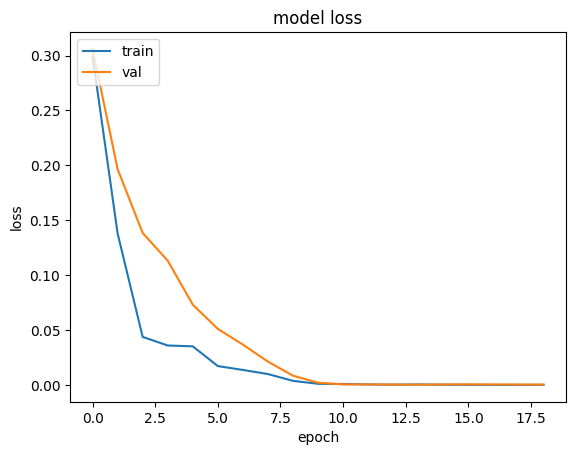

FDE : 0.0967314262687705, ADE : 0.05230797000170188
training time: 7.491219520568848
data num: 196


In [ ]:
datalist=dataFront

sc = MinMaxScaler()
sc_data=sc.fit_transform(datalist)
sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist.index)


w=int(input('window size: '))
start = time.time() #작동시간 체크 시작


############################################################################
############################################################################
data_sc_df=sc_df

for s in range(1, w):
  data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

k=w-1
X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False,random_state=0)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

X_train_t = X_train.reshape(X_train.shape[0], k, 2)
X_test_t=X_test.reshape(X_test.shape[0],k,2)

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
model.add(Dense(2)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

p=5 #int(input('patience : '))
early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test), batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
Y_validation=sc.inverse_transform(y_test)

loss_and_metrics = model.evaluate(X_test_t, y_test)
df_ = pd.DataFrame({'lat':Y_validation[:,0], 'lon':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
d=[]
for i in range(len(df_)):
  d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

ADE = avd(d)
FDE = d[-1]
r = result
df=df_
pred_df=y_pred_df
lo=loss_and_metrics


############################################################################
############################################################################

# ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w) 얘를 위에걸로 대치



end = time.time() #작동시간 체크 끝
training_time=end-start
      # summarize history for loss
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print('FDE : {}, ADE : {}'.format(FDE,ADE))
print('training time: {}' .format(training_time))
print('data num: {}' .format(len(datalist)))

ASW_map = folium.Map(location=[datalist['lat'].mean(),datalist['lon'].mean()],tiles='Stamen Toner',zoom_start=13)
d=[]

for i in range(len(datalist)-(w-1)):
  folium.Circle([datalist['lat'][i],datalist['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]
for i in range(len(pred_df)):
  folium.Circle([pred_df['prediction_lat'][i],pred_df['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
  folium.Circle([df['lat'][i],df['lon'][i]],radius=1,color='orange').add_to(ASW_map)
  d.append(haversine(pred_df['prediction_lat'][i],pred_df['prediction_lon'][i],df['lat'][i],df['lon'][i]))

#display(ASW_map)

window size: 4
Epoch 1/200
2/2 [==============================] - 11s 2s/step - loss: 0.1760 - accuracy: 0.8235 - val_loss: 0.2418 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 168ms/step - loss: 0.1360 - accuracy: 0.8235 - val_loss: 0.2180 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 132ms/step - loss: 0.1034 - accuracy: 0.8235 - val_loss: 0.1962 - val_accuracy: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 0s 145ms/step - loss: 0.0753 - accuracy: 0.8235 - val_loss: 0.1773 - val_accuracy: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 0s 146ms/step - loss: 0.0513 - accuracy: 0.8235 - val_loss: 0.1621 - val_accuracy: 0.0000e+00
Epoch 6/200
2/2 [==============================] - 0s 151ms/step - loss: 0.0323 - accuracy: 0.8235 - val_loss: 0.1514 - val_accuracy: 0.0000e+00
Epoch 7/200
2/2 [==============================] - 0s 141ms/step - loss: 0.0194 - accuracy: 0.8235 - val_loss: 0.1456

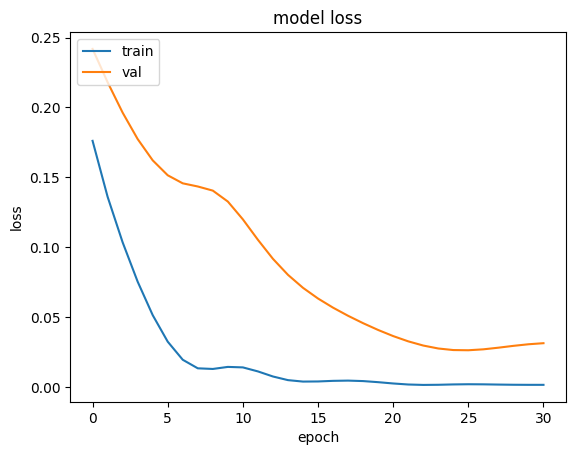

FDE : 0.08950307093998647, ADE : 0.05806951800589988
training time: 20.249990701675415
data num: 196


In [ ]:
datalist2=dataBack

sc = MinMaxScaler()
sc_data=sc.fit_transform(datalist2)
sc_df = pd.DataFrame(sc_data, columns=['Scaled_lat','Scaled_lon'], index=datalist2.index)


w=int(input('window size: '))
start = time.time() #작동시간 체크 시작


############################################################################
############################################################################
data_sc_df=sc_df

for s in range(1, w):
  data_sc_df['shift_{}_lat'.format(s)],data_sc_df['shift_{}_lon'.format(s)] = data_sc_df['Scaled_lat'].shift(s),data_sc_df['Scaled_lon'].shift(s)

k=w-1
X_data = data_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_data = data_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,shuffle=False,random_state=0)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

X_train_t = X_train.reshape(X_train.shape[0], k, 2)
X_test_t=X_test.reshape(X_test.shape[0],k,2)

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(300, input_shape=(k, 2))) # (timestep, feature)
model.add(Dense(2)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

p=5 #int(input('patience : '))
early_stop = EarlyStopping(monitor='val_loss',mode='auto',patience=p, verbose=1)

result=model.fit(X_train_t, y_train, epochs=200,validation_data=(X_test_t,y_test), batch_size=32, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
Y_validation=sc.inverse_transform(y_test)

loss_and_metrics = model.evaluate(X_test_t, y_test)
df_ = pd.DataFrame({'lat':Y_validation[:,0], 'lon':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
d=[]
for i in range(len(df_)):
  d.append(haversine(df_.iloc[i][0],df_.iloc[i][1],y_pred[i][0],y_pred[i][1]))

ADE2 = avd(d)
FDE2 = d[-1]
r2 = result
df2=df_
pred_df2=y_pred_df
lo2=loss_and_metrics


############################################################################
############################################################################

# ADE,FDE,r,df,pred_df,lo=run_predict(sc_df,w) 얘를 위에걸로 대치



end = time.time() #작동시간 체크 끝
training_time=end-start
      # summarize history for loss
plt.plot(r2.history['loss'])
plt.plot(r2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print('FDE : {}, ADE : {}'.format(FDE2,ADE2))
print('training time: {}' .format(training_time))
print('data num: {}' .format(len(datalist)))

#ASW_map = folium.Map(location=[datalist2['lat'].mean(),datalist2['lon'].mean()],tiles='Stamen Toner',zoom_start=13)
d=[]

for i in range(len(datalist) - (w-1)):
  folium.Circle([datalist['lat'][i],datalist['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]
for i in range(len(datalist2) - (w-1)):
  folium.Circle([datalist2['lat'][i],datalist2['lon'][i]],radius=1,color='blue').add_to(ASW_map)#, popup=df_cities.index[i]
for i in range(len(pred_df2)):
  folium.Circle([pred_df2['prediction_lat'][i],pred_df2['prediction_lon'][i]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
  folium.Circle([df2['lat'][i],df2['lon'][i]],radius=1,color='orange').add_to(ASW_map)
  d.append(haversine(pred_df2['prediction_lat'][i],pred_df2['prediction_lon'][i],df2['lat'][i],df2['lon'][i]))

display(ASW_map)